In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib notebook
%config InlineBackend.print_figure_kwargs={'bbox_inches': None}
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
from scipy.stats import norm
from matplotlib.colors import ListedColormap
import IPython
from IPython.display import display, HTML
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
df_final = pd.read_csv("../../../data/updated_dataset/modif_final.csv",sep=",",low_memory=False)

In [3]:
df_final.shape

(2150, 154)

##### Rearrange table as in the preprocessed step

In [4]:
df_final.set_index(df_final['Unnamed: 0'].unique(),inplace=True)
df_final.drop('Unnamed: 0', axis=1, inplace=True)
df_final.set_index('data_pd',inplace=True)

##### Let's look at in details the variables

###### First, we will need to remove the sample_pd and data_pd to have numeric variables to work with

In [5]:
df_final = df_final.iloc[:,1:]
df_final.shape

(2150, 151)

In [9]:
### Kind of comutation similarity
cols=df_final.columns
#h = pd.DataFrame(columns=df_final.columns)
h = pd.DataFrame(columns=cols)
#h.set_index(["ASXL1","ASXL2","ASXL3"],inplace=True)

#for i,col in enumerate(df_final.columns):
for i,col in enumerate(cols):
    h.loc[cols[i],cols[i]]=1
    for j, colum in enumerate([c for c in cols if c!=col]):
        h.loc[cols[i],colum] = df_final[(df_final[col]==1) & (df_final[colum]==1)].shape[0] / df_final[(df_final[col]==1)].shape[0]
# h

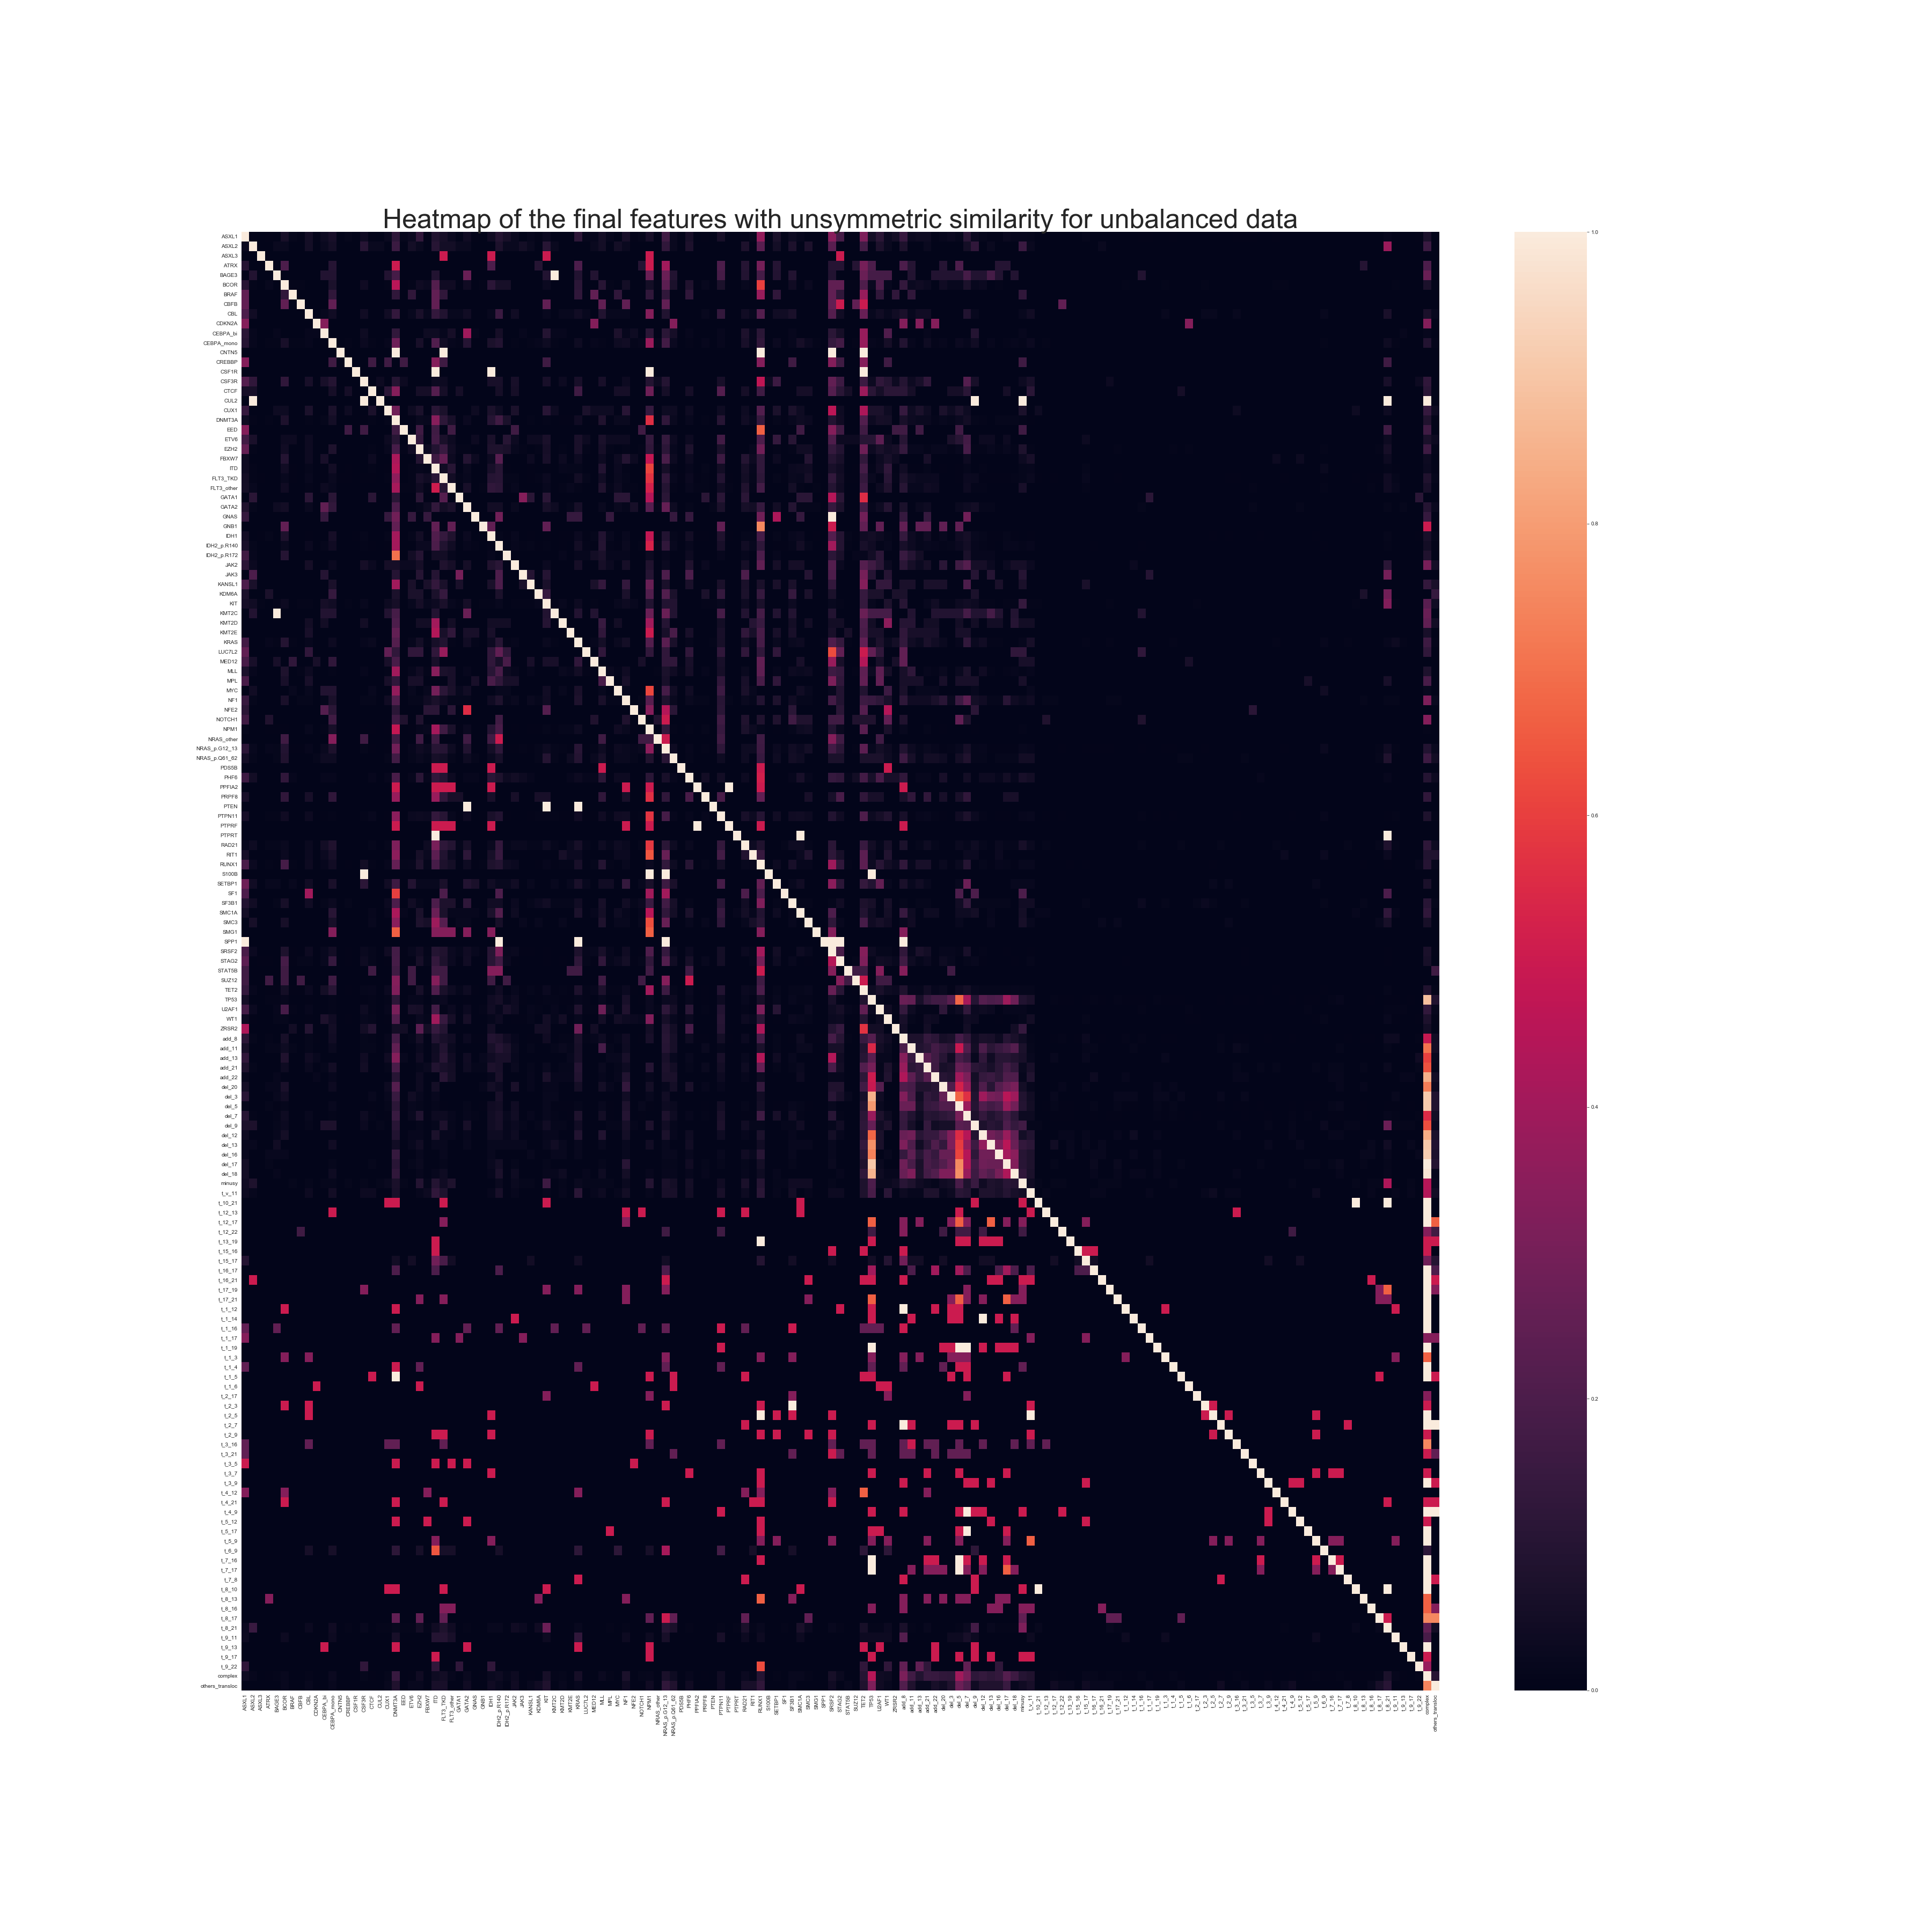

In [76]:
plt.figure(figsize=(50,50))
plt.title('Heatmap of the final features with unsymmetric similarity for unbalanced data',fontsize=50)
sns.heatmap(h.fillna(0),xticklabels=True, yticklabels=True)
plt.show()

##### Heatmap using jaccard similarity

/Users/taziy/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


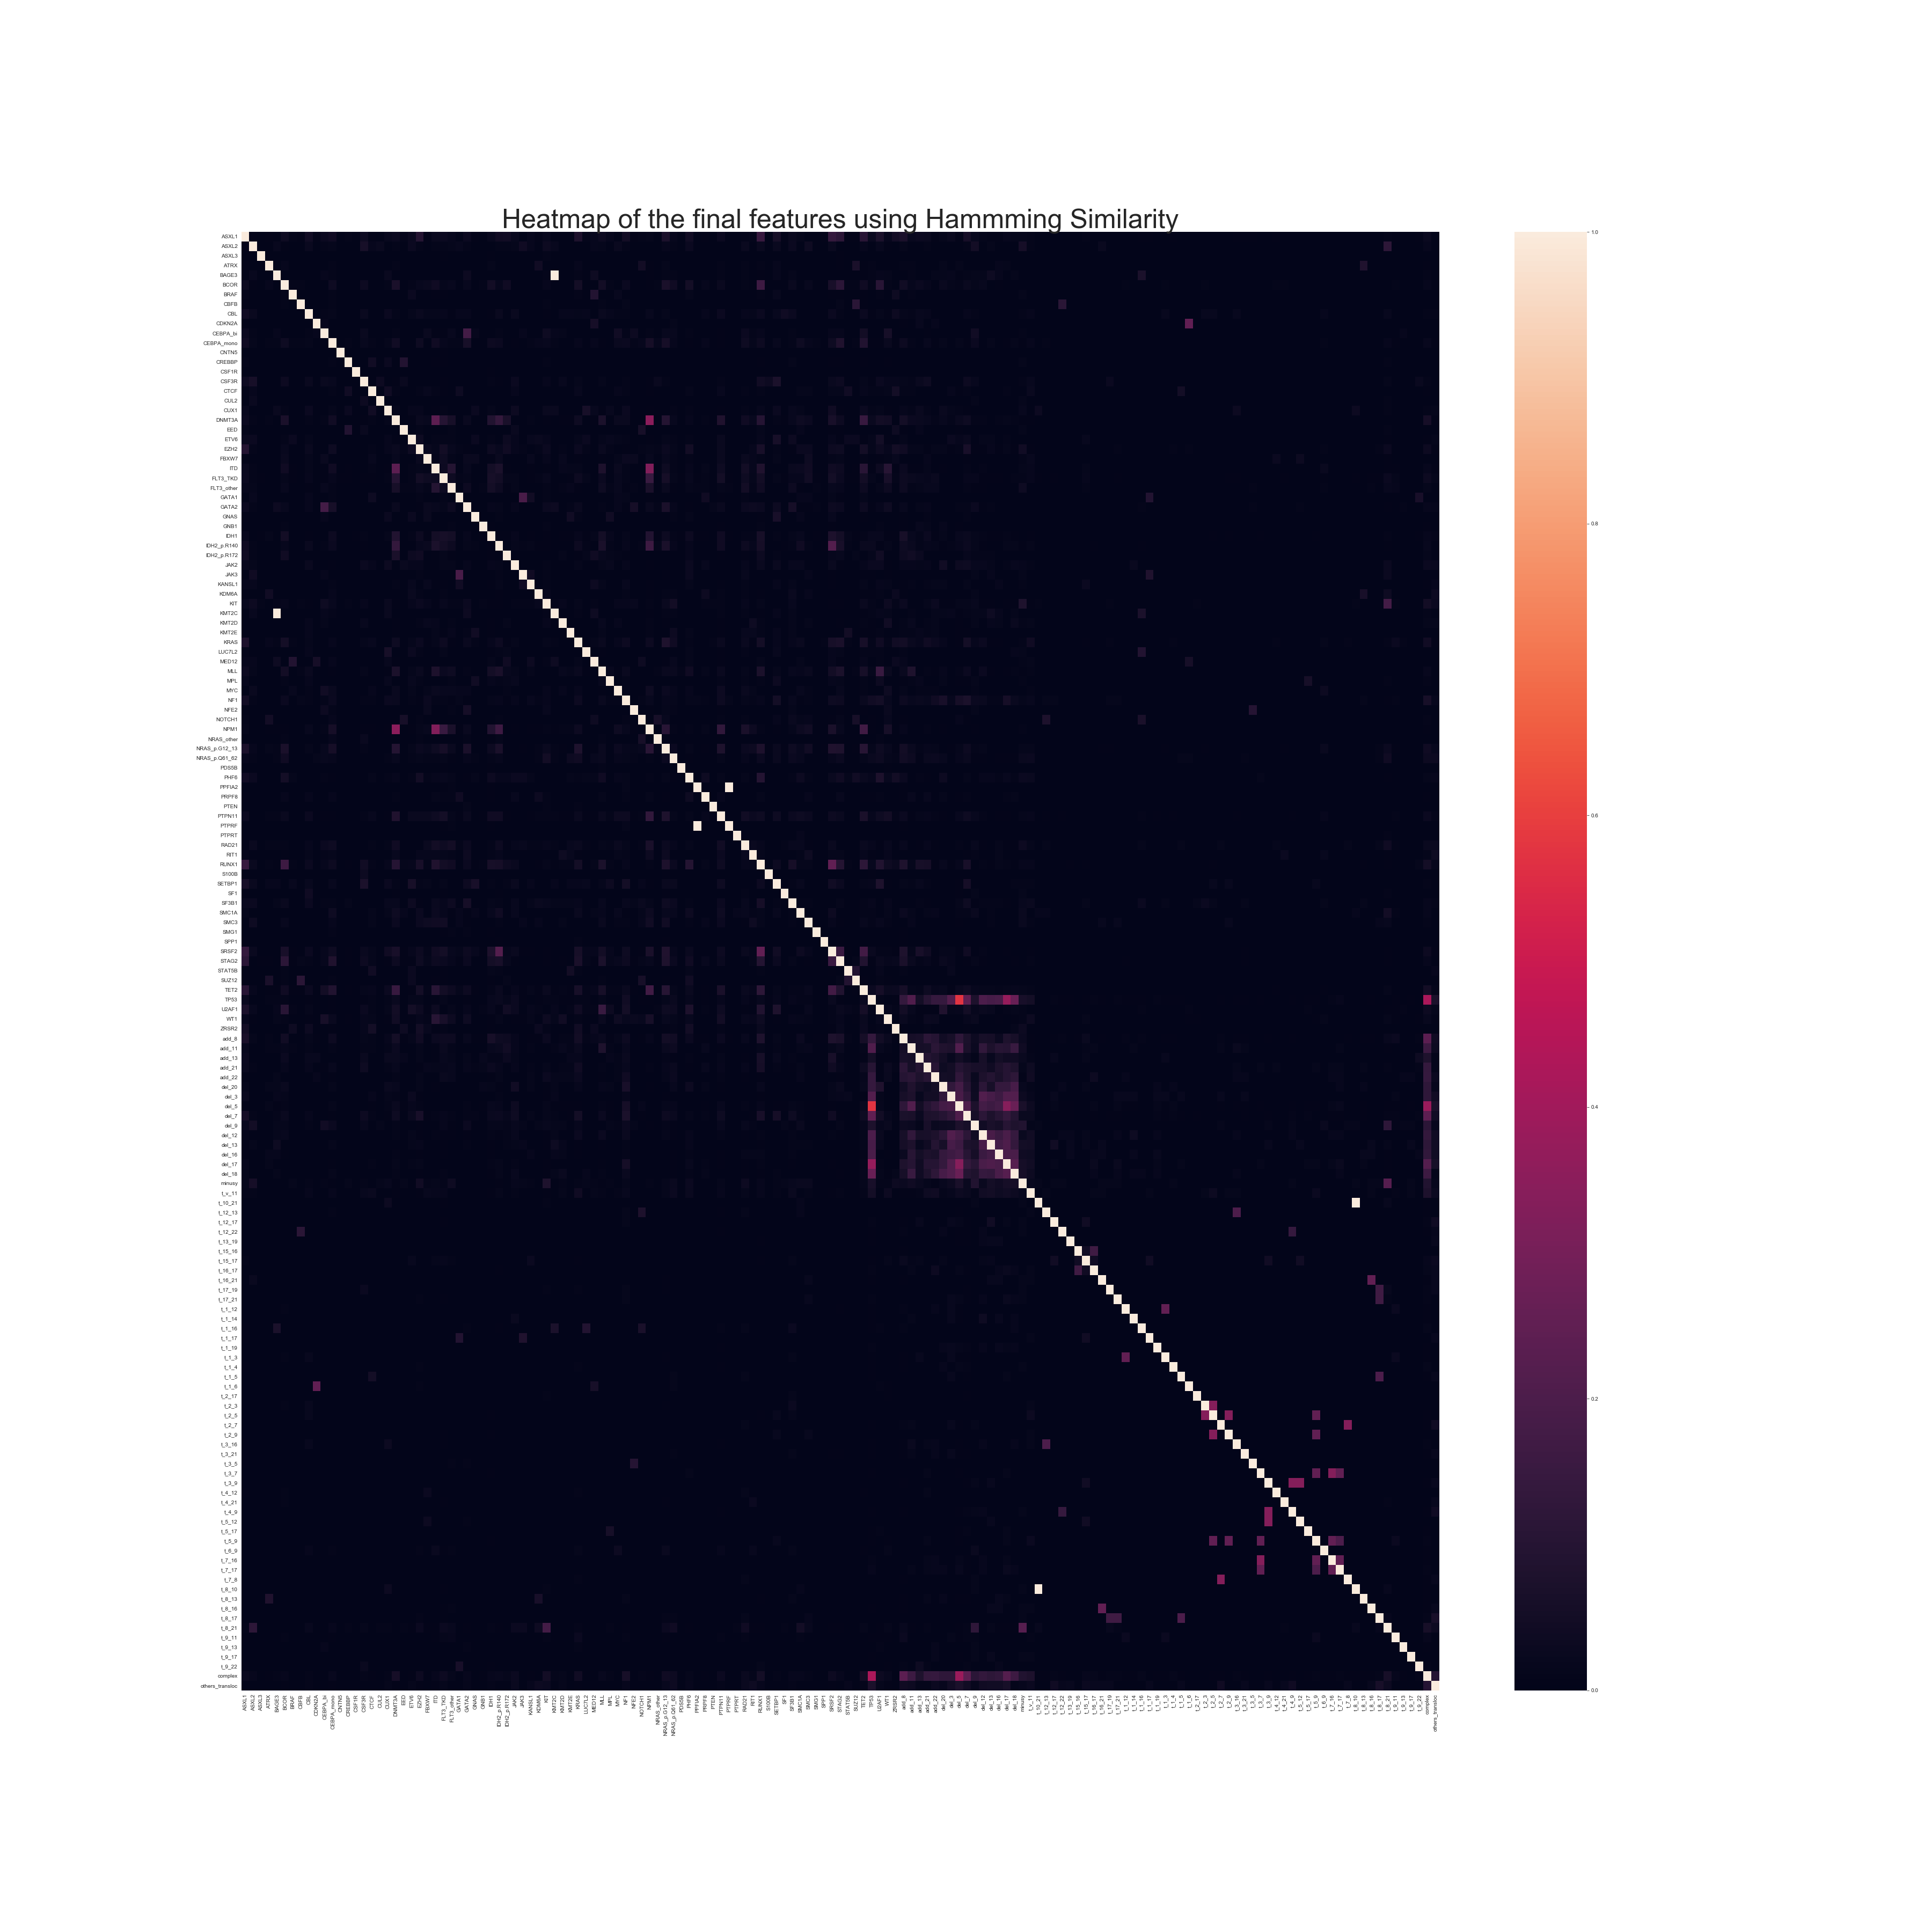

In [16]:
jac_sim = 1 - pairwise_distances(df_final.T, metric = "jaccard")
jac_sim = pd.DataFrame(jac_sim, index=df_final.columns, columns=df_final.columns)
plt.figure(figsize=(50,50))
plt.title('Heatmap of the final features using Hammming Similarity',fontsize=50)
sns.heatmap(jac_sim,xticklabels=True, yticklabels=True)
plt.show()

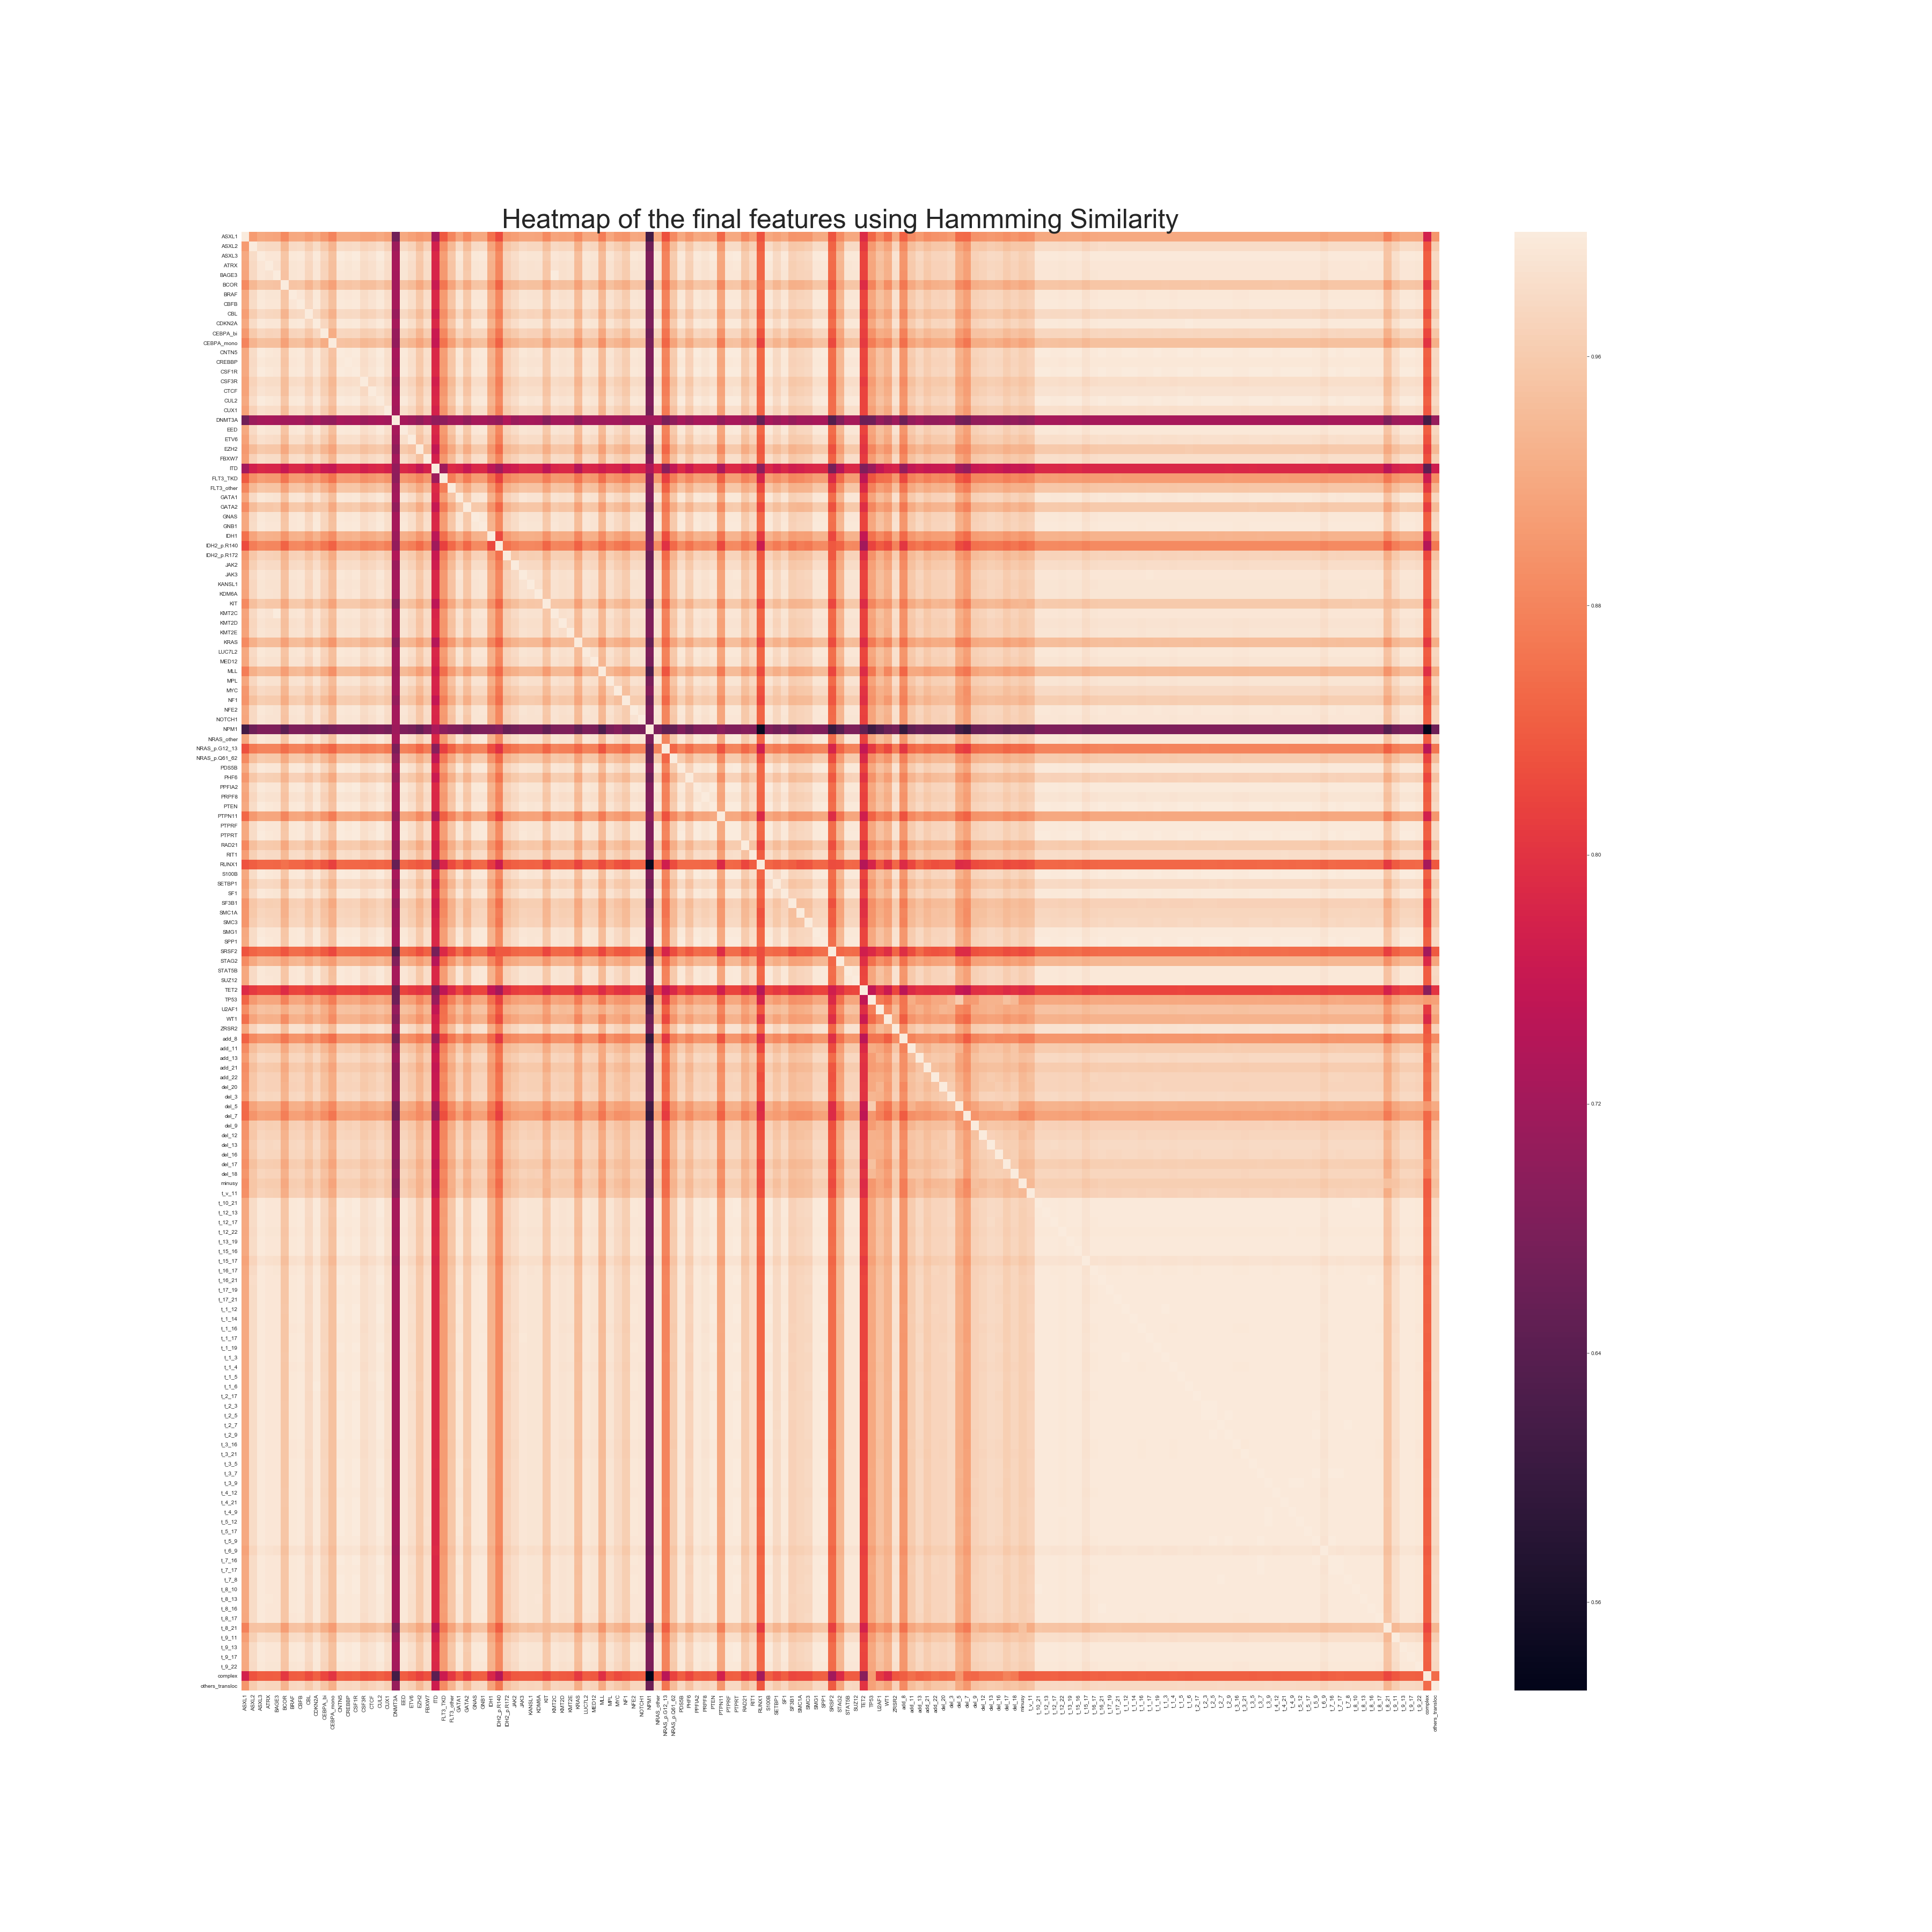

In [15]:
jac_sim = 1 - pairwise_distances(df_final.T, metric = "hamming")
jac_sim = pd.DataFrame(jac_sim, index=df_final.columns, columns=df_final.columns)
plt.figure(figsize=(50,50))
plt.title('Heatmap of the final features using Hammming Similarity',fontsize=50)
sns.heatmap(jac_sim,xticklabels=True, yticklabels=True)
plt.show()

##### Heatmap using pearson coefficient 

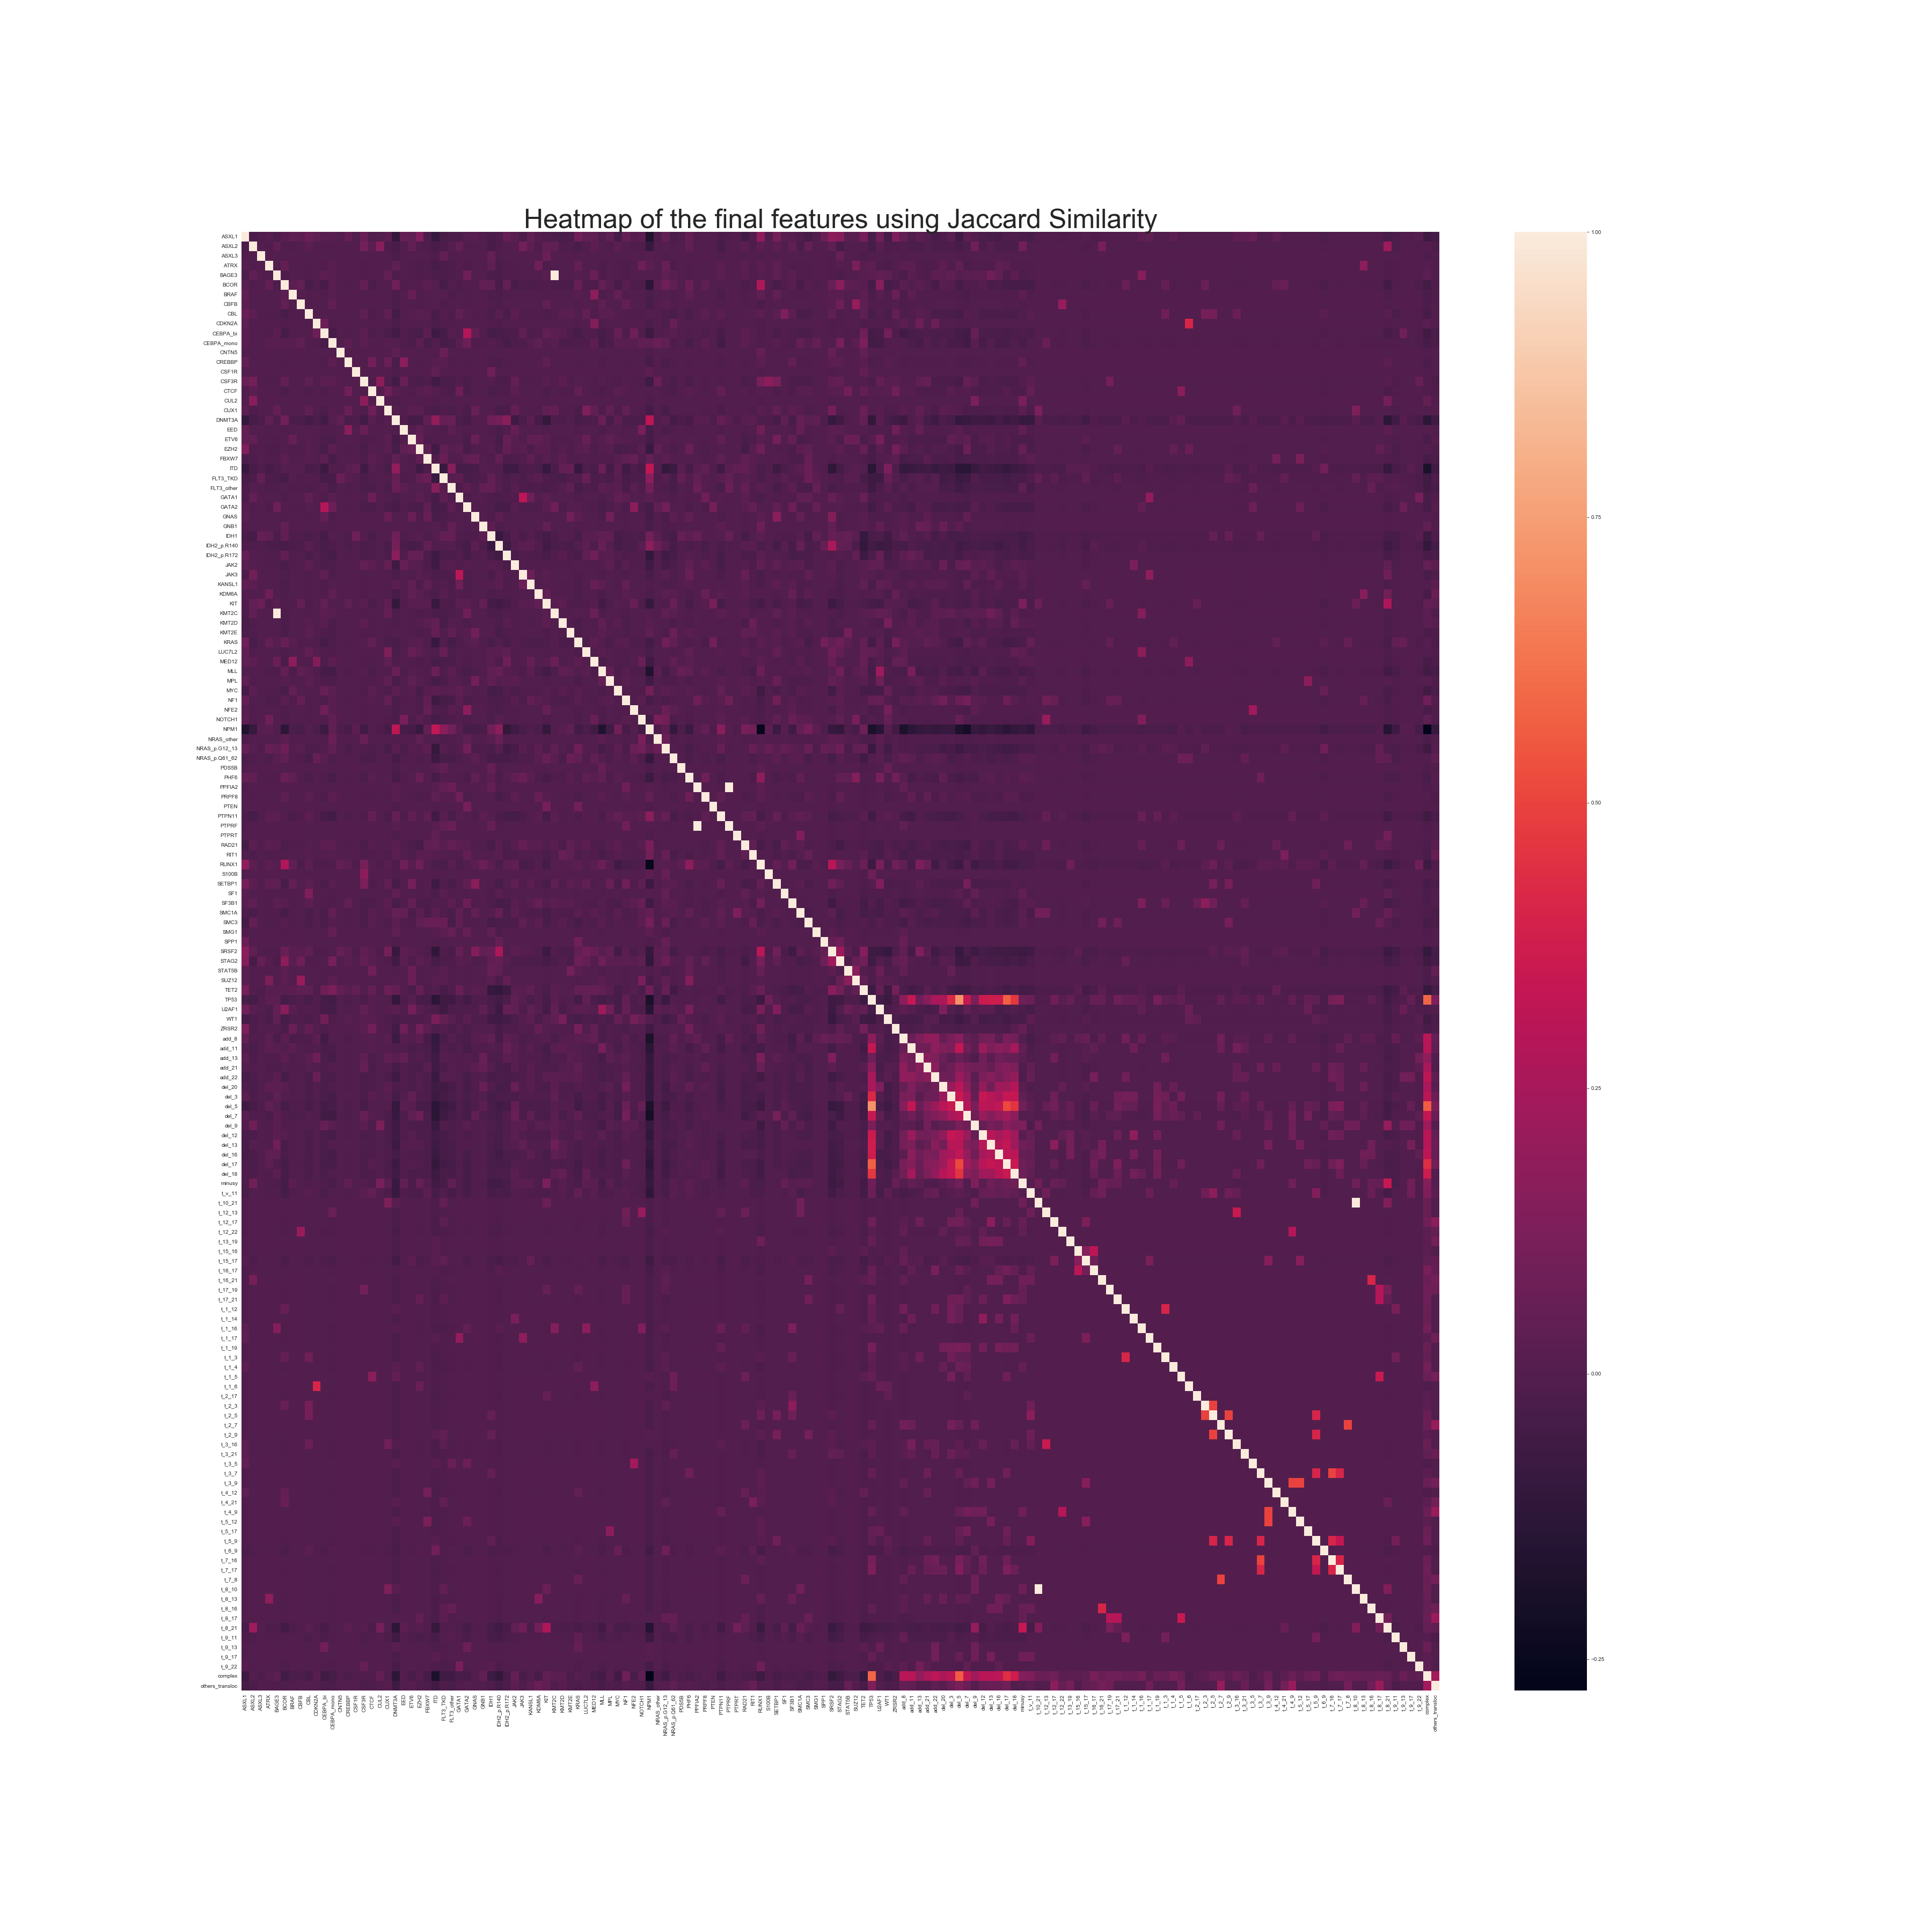

In [25]:

plt.figure(figsize=(50,50))
plt.title('Heatmap of the final features using Jaccard Similarity',fontsize=50)
sns.heatmap(df_final.corr('kendall'),xticklabels=True, yticklabels=True)
plt.savefig("heatmap.png")
plt.show()


##### Let's look at the comutations:

In [58]:
tmp=df_final[['KMT2C','BAGE3']]
display(tmp[tmp['BAGE3']==1 ])

,KMT2C,BAGE3
data_pd,,
PD20112a,1,1
PD15123a,1,1
PD15068a,1,1
PD22660a,1,1
PD22943a,1,1
PD23112c,1,1
PD23136a,1,1
PD25061a,1,1
PD25160c,1,1


In [59]:
tmp = df_final[['PTPRF','PPFIA2']]
(tmp[tmp['PTPRF']==1 ])

,PTPRF,PPFIA2
data_pd,,
PD15281a,1,1
PD25183a,1,1


#### Let's see if we can spot something by looking at the hamming distance . 
Nothing interesting spotted : the IOU is high because usuall

In [60]:
arr = (1 - pairwise_distances(df_final.T, metric = "hamming"))
lis = [(ix,iy) for ix, row in enumerate(arr) for iy, i in enumerate(row) if (i < 0.999 and i>0.998 and ix!=iy)]


# CLUSTERING METHODS

### I) Clustering with kmeans and Elbow Method

#### Let's first plot the elbow curve for different k representing the number of cluster

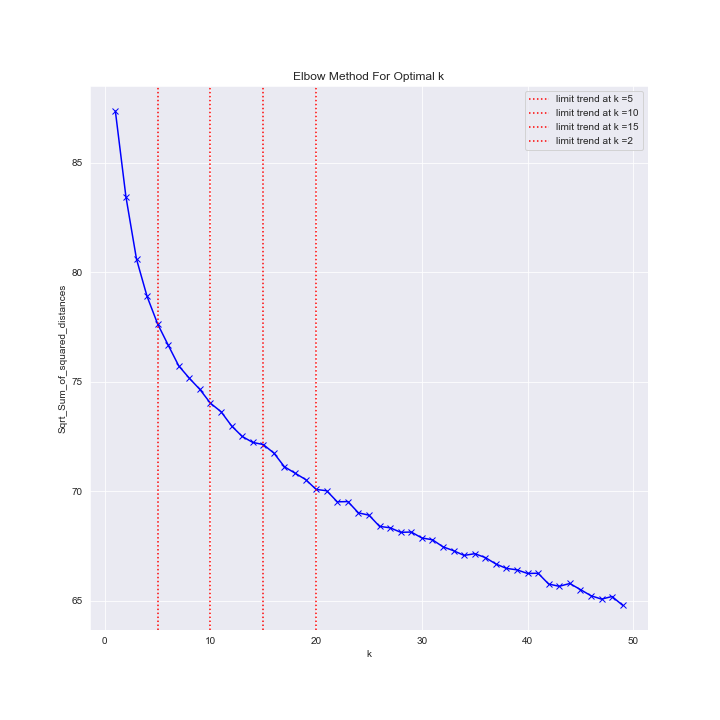

In [15]:
import numpy as np
Sqrt_Sum_of_squared_distances = []
K = range(1,50)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_final)
    Sqrt_Sum_of_squared_distances.append(np.sqrt(km.inertia_))
plt.figure(figsize=(10,10))
plt.plot(K, Sqrt_Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sqrt_Sum_of_squared_distances')
plt.axvline(x=5, label='limit trend at k ={}'.format(5), c='r',linestyle='dotted')
plt.axvline(x=10, label='limit trend at k ={}'.format(10), c='r',linestyle='dotted')
plt.axvline(x=15, label='limit trend at k ={}'.format(15), c='r',linestyle='dotted')
plt.axvline(x=20, label='limit trend at k ={}'.format(2), c='r',linestyle='dotted')
plt.title('Elbow Method For Optimal k')
plt.legend()
plt.show()

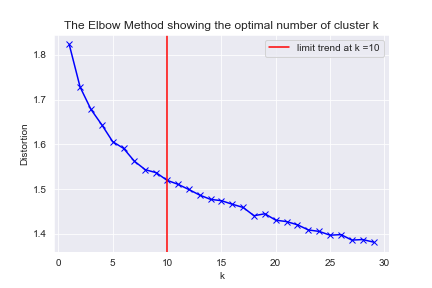

In [62]:
distortions = []
K = range(1,30)
for k in K:
    kmeanModel = KMeans(n_clusters=k,random_state=423).fit(df_final)
    #kmeanModel.fit(df_final)
    distortions.append(np.sum(np.min(cdist(df_final, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / df_final.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal number of cluster k')
plt.axvline(x=10, label='limit trend at k ={}'.format(10), c='r')
#plt.axvline(x=7, label='limit trend at k ={}'.format(7), c='g')
plt.legend()
plt.show()

### II) Feature importance with kMeans and Random Forest on top of it for the feature importance

#### Now that we have approximate a good number of clusters, let's look at the feature importance

In [63]:
model = KMeans(n_clusters=10).fit(df_final)
model.fit(df_final)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

#### Let's look at how many points assigned by cluster

In [64]:
from collections import Counter
dict(Counter(model.labels_))

{6: 135,
 0: 151,
 3: 234,
 2: 160,
 4: 621,
 5: 215,
 7: 205,
 8: 172,
 9: 157,
 1: 100}

2150
True


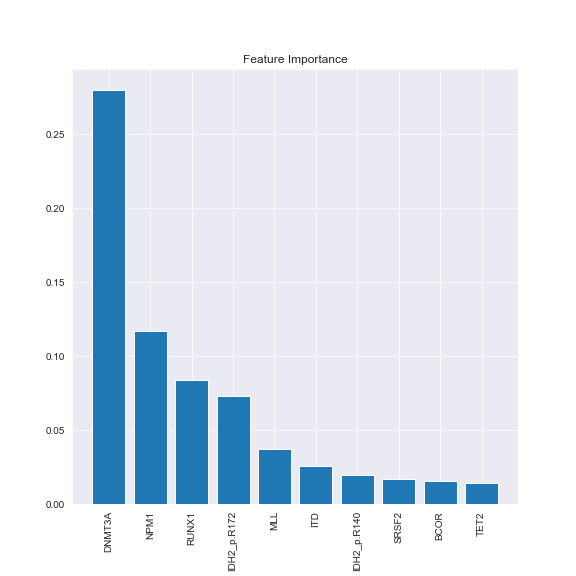

2150
True


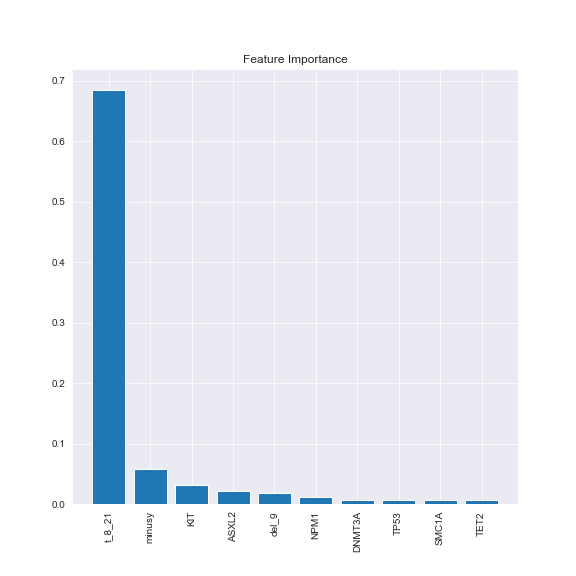

2150
True


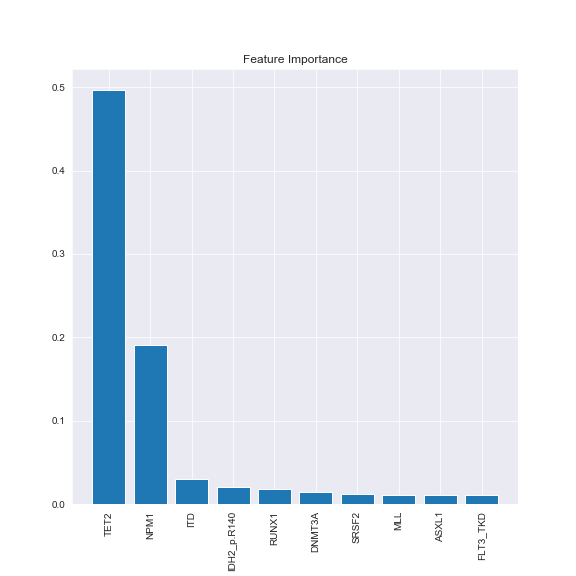

2150
True


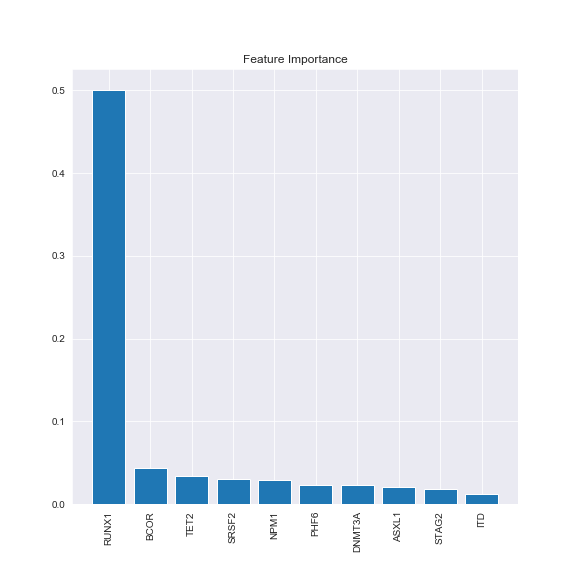

2150
True


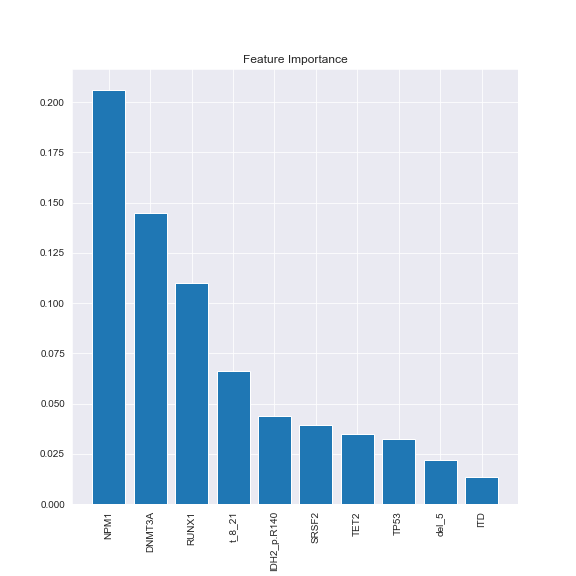

2150
True


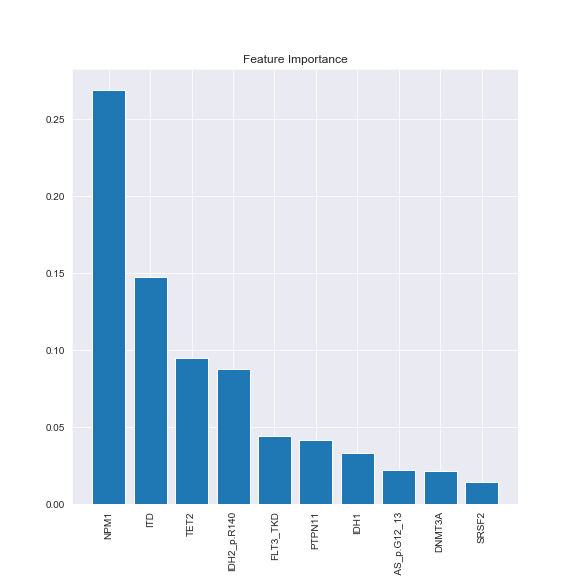

2150
True


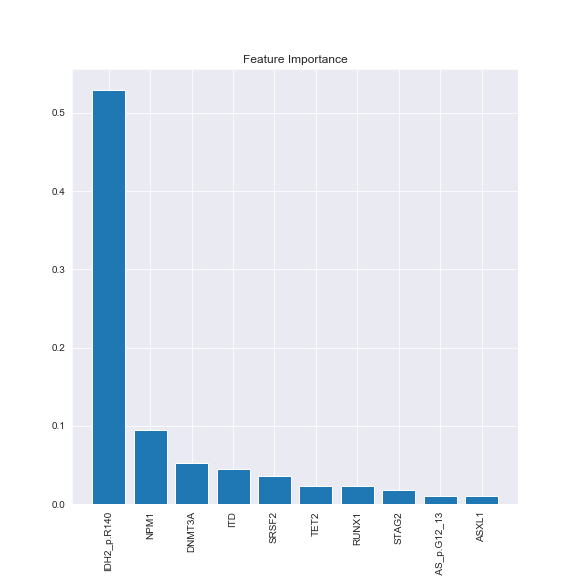

2150
True


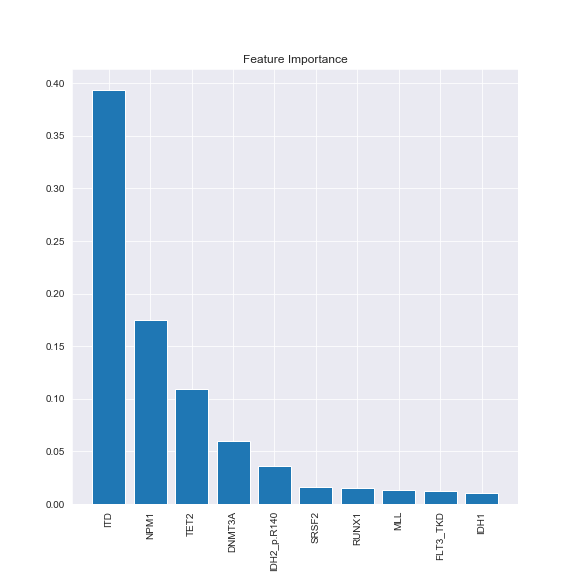

2150
True


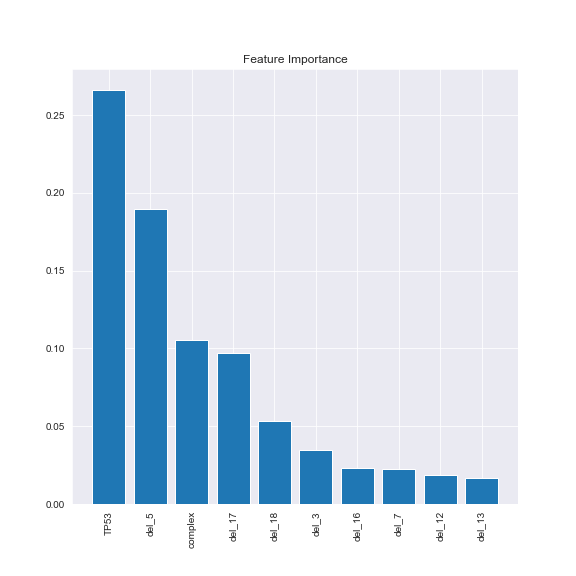

2150
True


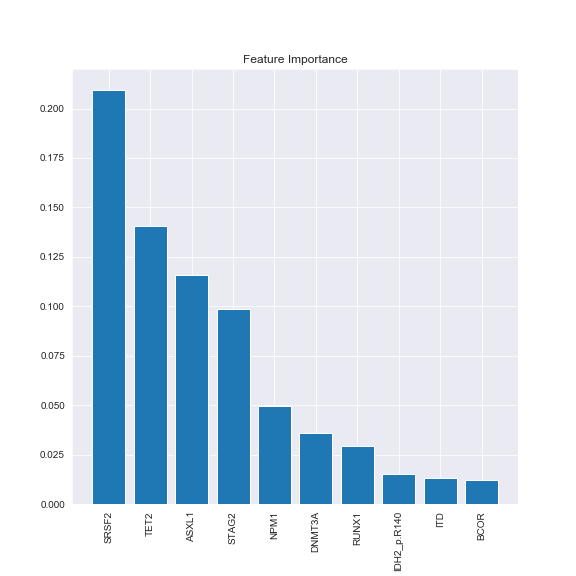

In [65]:
for i in range(10):
    y = [1 if m == i else 0 for m in model.labels_]
    l=list(model.labels_)
    print (len(l))

    
    #Check if association works
    print([index for index, value in enumerate(l) if value == i]==[index for index, value in enumerate(y) if value == 1])
    X_train, X_test, y_train, y_test = train_test_split(df_final, y, test_size=0.3, random_state=0)
    # Train the classifier
    clf = RandomForestClassifier(n_estimators=500, random_state=0, n_jobs=-1)
    #clf.fit(X_train, y_train)
    clf.fit(df_final, y)

    # Print the name and gini importance of each feature (verify that sum is 1)
    importances = clf.feature_importances_
    # Sort feature importances in descending order
    indices = np.argsort(importances)[::-1]
    #print (df_gene.columns[65])
    #print (indices[:5])
    indices=indices[:10]
    # Rearrange feature names so they match the sorted feature importances
    names = [df_final.columns[i] for i in indices]
    plt.figure(figsize=(8,8))
    # Create plot title
    plt.title("Feature Importance")

    # Add bars
    plt.bar(range(10), importances[indices])

    # Add feature names as x-axis labels
    plt.xticks(range(10), names, rotation=90)

    # Show plot
    plt.show()

### II) Clustering with DBScan

In [71]:
from sklearn.cluster import DBSCAN
import pandas as pd
import numpy as np
from sklearn.neighbors import DistanceMetric


import pandas as pd
import numpy as np
from sklearn.neighbors import DistanceMetric


def gower_distance(X):
    """
    This function expects a pandas dataframe as input
    The data frame is to contain the features along the columns. Based on these features a
    distance matrix will be returned which will contain the pairwise gower distance between the rows
    All variables of object type will be treated as nominal variables and the others will be treated as 
    numeric variables.
    Distance metrics used for:
    Nominal variables: Dice distance (https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient)
    Numeric variables: Manhattan distance normalized by the range of the variable (https://en.wikipedia.org/wiki/Taxicab_geometry)
    """
    individual_variable_distances = []

    for i in range(X.shape[1]):
        feature = X.iloc[:,[i]]
        if feature.dtypes[0] == np.object:
            feature_dist = DistanceMetric.get_metric('dice').pairwise(pd.get_dummies(feature))
        else:
            feature_dist = DistanceMetric.get_metric('manhattan').pairwise(feature) / max(np.ptp(feature.values),1)

        individual_variable_distances.append(feature_dist)

    return np.array(individual_variable_distances).mean(0)
X=StandardScaler().fit_transform(df_final)
clustering = DBSCAN().fit(X)
dict(Counter(clustering.labels_))

/Users/taziy/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/taziy/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


{0: 12,
 1: 8,
 -1: 1818,
 2: 6,
 3: 5,
 4: 6,
 5: 13,
 6: 6,
 7: 7,
 8: 6,
 9: 12,
 10: 43,
 11: 56,
 12: 5,
 13: 11,
 14: 13,
 15: 6,
 16: 5,
 17: 11,
 18: 10,
 19: 7,
 20: 6,
 21: 7,
 22: 6,
 23: 9,
 24: 14,
 25: 6,
 26: 8,
 27: 7,
 28: 10,
 29: 5,
 30: 6}

### III) Mean Shift Clustering Algorithm

In [67]:
from sklearn.cluster import MeanShift
ms = MeanShift().fit(X)
import sklearn
ms = MeanShift(bandwidth=sklearn.cluster.estimate_bandwidth(X,quantile=0.5)).fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)
print("number of estimated clusters : %d" % n_clusters_)
#dict(Counter(ms.labels_))

number of estimated clusters : 143
